In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import numpy as np
from numpy import random
database = 'database.sqlite'
conn = sqlite3.connect('../../database/database.sqlite')
sql = """select league_id,season,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A from Match where league_id=21518 or league_id= 1729 or league_id=4769 or league_id=10257"""                  

data = pd.read_sql(sql,conn)

#Converting season values

def change_season(match):
    if match['season'] =='2008/2009':
        return 0
    elif match['season'] =='2009/2010':
        return 1
    elif match['season'] =='2010/2011':
        return 2
    elif match['season'] =='2011/2012':
        return 3
    elif match['season'] =='2012/2013':
        return 4
    elif match['season'] =='2013/2014':
        return 5
    elif match['season'] =='2014/2015':
        return 6
    else:
        return 7
    
data['season']=data.apply(change_season, axis=1) 

#Classifing Match output
def determine_home_result(match):
    if match['home_team_goal'] > match['away_team_goal']:
        return 1
    elif match['home_team_goal'] < match['away_team_goal']:
        return 2
    else:
        return 0
    
    
data['Output']=data.apply(determine_home_result, axis=1)

data= data.dropna()

train_value = 4
val_value = 5
test_value = 6

from sklearn.metrics import log_loss


train = data[data['season']<=train_value]
val = data[data['season']==val_value]
test = data[data['season']>=test_value]

ft_raw=['league_id','season','stage','home_team_api_id','away_team_api_id','B365H','B365D','B365A']
out='Output'

In [2]:
from sklearn import linear_model
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

C= [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag']
n = range(100,1000,50)
lr= [0.0001, 0.001, 0.01, 0.1]
k = range(1,100,2)
knn_algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

def pca_logreg_validation(C,solver,train,val,train_y,val_y,seed):
    sc_max = -10000
    best=[]
    for s in solver:
        for cv in C:
            lg = linear_model.LogisticRegression(C=cv,solver=s,n_jobs=-1,max_iter=100000,random_state=seed)
            lg.fit(train,train_y)
            score = f1_score(val_y, lg.predict(val),average='weighted')
            if score>sc_max:
                best=lg
                sc_max=score
    return best
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def pca_rf_validation(n_estimators,train,val,train_y,val_y,seed):
    sc_max = -10000
    best=[]
    for n in n_estimators:
        rf = RandomForestClassifier(n_estimators=n,n_jobs=-1,random_state=seed)
        rf.fit(train,train_y)
        score = f1_score(val_y, rf.predict(val),average='weighted')
        if score>sc_max:
            best=rf
            sc_max=score
    return best

n = range(100,1000,50)

#rf= rf_validation(n,train,val,ft,out)


#Função Naive Bayes
from sklearn.naive_bayes import GaussianNB

def pca_nb_validation(train,val,train_y,val_y):
    nb = GaussianNB()
    nb.fit(train,train_y)
    return nb


#Gradient Boosting
def pca_gb_validation(learning_rate,n_estimators,train,val,train_y,val_y,seed):
    sc_max = -10000
    best=[]
    for n in n_estimators:
        for lr in learning_rate:
            gb = GradientBoostingClassifier(learning_rate=lr,n_estimators=n,random_state=seed)
            gb.fit(train,train_y)
            score = f1_score(val_y, gb.predict(val),average='weighted')
            if score>sc_max:
                best=gb
                sc_max=score
    return best
from sklearn.neighbors import KNeighborsClassifier
def pca_knn_validation(algorithms,k,train,val,train_y,val_y,seed):
    sc_max = -10000
    best=[]
    for alg in algorithms:
        for n in k:
            knn = KNeighborsClassifier(algorithm=alg,n_neighbors=n)
            knn.fit(train,train_y)
            score = f1_score(val_y, knn.predict(val),average='weighted')
            if score>sc_max:
                best=knn
                sc_max=score
        return best
seeds = [1,2,3,4,5]

def all_algorithms(train,val,test,train_y,val_y,test_y,seeds):
    logregs=[]
    rfs=[]
    gbs=[]
      
    for s in seeds:
        print "------",s,"------"
        print "LogReg"
        logreg=pca_logreg_validation(C,solver,train,val,train_y,val_y,s)
        logregs.append(logreg)
        print "NB"
        nb= pca_nb_validation(train,val,train_y,val_y)
        print "RF"
        n = range(100,1000,50)
        lr= [0.0001, 0.001, 0.01, 0.1]
        rf= pca_rf_validation(n,train,val,train_y,val_y,s)
        rfs.append(rf)
        print "GB"
        gb= pca_gb_validation(lr,n,train,val,train_y,val_y,s)
        gbs.append(gb)
        print "KNN"
        knn= pca_knn_validation(knn_algorithms,k,train,val,train_y,val_y,s)
        #GaussianProcess
        ynaive = [train_y.mode()[0]]*len(test)
        naive = f1_score(test_y,ynaive,average='weighted')
        #print "logreg
        print "\t\tF1Score\t","      F1 macro\t","    F1 micro"
        print "Naive      ", naive,f1_score(test_y,ynaive,average='macro'),f1_score(test_y,ynaive,average='micro')
        print "LogReg     ", f1_score(test_y,logreg.predict(test),average='weighted'),f1_score(test_y,logreg.predict(test),average='macro'),f1_score(test_y,logreg.predict(test),average='micro')
        print "Naive Bayes", f1_score(test_y,nb.predict(test),average='weighted'),f1_score(test_y,nb.predict(test),average='macro'),f1_score(test_y,nb.predict(test),average='micro')
        print "Random F.  ", f1_score(test_y,rf.predict(test),average='weighted'),f1_score(test_y,rf.predict(test),average='macro'),f1_score(test_y,rf.predict(test),average='micro')
        print "G. Boost.  ", f1_score(test_y,gb.predict(test),average='weighted'),f1_score(test_y,gb.predict(test),average='macro'),f1_score(test_y,gb.predict(test),average='micro')
        print "KNN        ", f1_score(test_y,knn.predict(test),average='weighted'),f1_score(test_y,knn.predict(test),average='macro'),f1_score(test_y,knn.predict(test),average='micro')
    return logregs,nb,rfs,gbs,knn
    #return logreg,nb,rf,gb,knn
#lr= [0.0001, 0.001, 0.01, 0.1]

In [3]:
logreg_raw,nb_raw,rf_raw,gb_raw,knn_raw=all_algorithms(train[ft_raw],val[ft_raw],test[ft_raw],train['Output'],val['Output'],test['Output'],seeds)

------ 1 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.433193404296 0.379776446747 0.521066491113
Naive Bayes 0.434302826399 0.384308784572 0.507570770244
Random F.   0.473410841294 0.438161771126 0.501316655695
G. Boost.   0.463904689394 0.428732366293 0.489795918367
KNN         0.402295823232 0.369208804094 0.426925608953
------ 2 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.433193404296 0.379776446747 0.521066491113
Naive Bayes 0.434302826399 0.384308784572 0.507570770244
Random F.   0.476027705927 0.442404052694 0.500329163924
G. Boost.   0.463664718296 0.428435218326 0.489466754444
KNN         0.402295823232 0.369208804094 0.426925608953
------ 3 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.433193404296 0.37977644

In [4]:
rf_raw

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_jobs=-1, oob_score=False, random_state=1,
             verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_jobs=-1, oob_score=False, random_state=2,
             verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             mi

In [5]:
featured = pd.read_csv('dados2.csv')
featured['Output']=featured.apply(determine_home_result, axis=1)
featured['season']=featured.apply(change_season, axis=1) 

featured= featured.dropna()

train_value = 4
val_value = 5
test_value = 6

train_ft = featured[featured['season']<=train_value]
val_ft = featured[featured['season']==val_value]
test_ft = featured[featured['season']>=test_value]

ft=[u'hg_V', u'hg_D', u'hg_E', u'hg_GF', u'hg_AVG_GF', u'hg_GS',
       u'hg_AVG_GS', u'hg_J1GS', u'hg_J1GF', u'hg_BTTS', u'hg_Over2',
       u'hg_Over3', u'hg_Over4', u'hg_WinningCleanSheet', u'hg_LosingFS',
       u'hg_FailedScore', u'hg_CleanSheet', u'hg_AVG_GOALS', u'hgc_V',
       u'hgc_D', u'hgc_E', u'hgc_GF', u'hgc_AVG_GF', u'hgc_GS',
       u'hgc_AVG_GS', u'hgc_J1GS', u'hgc_J1GF', u'hgc_BTTS', u'hgc_Over2',
       u'hgc_Over3', u'hgc_Over4', u'hgc_WinningCleanSheet',
       u'hgc_LosingFS', u'hgc_FailedScore', u'hgc_CleanSheet',
       u'hgc_AVG_GOALS', u'hl_V', u'hl_D', u'hl_E', u'hl_GF', u'hl_AVG_GF',
       u'hl_GS', u'hl_AVG_GS', u'hl_J1GS', u'hl_J1GF', u'hl_BTTS',
       u'hl_Over2', u'hl_Over3', u'hl_Over4', u'hl_WinningCleanSheet',
       u'hl_LosingFS', u'hl_FailedScore', u'hl_CleanSheet',
       u'hl_AVG_GOALS', u'hlc_V', u'hlc_D', u'hlc_E', u'hlc_GF',
       u'hlc_AVG_GF', u'hlc_GS', u'hlc_AVG_GS', u'hlc_J1GS', u'hlc_J1GF',
       u'hlc_BTTS', u'hlc_Over2', u'hlc_Over3', u'hlc_Over4',
       u'hlc_WinningCleanSheet', u'hlc_LosingFS', u'hlc_FailedScore',
       u'hlc_CleanSheet', u'hlc_AVG_GOALS', u'ag_V', u'ag_D', u'ag_E',
       u'ag_GF', u'ag_AVG_GF', u'ag_GS', u'ag_AVG_GS', u'ag_J1GS',
       u'ag_J1GF', u'ag_BTTS', u'ag_Over2', u'ag_Over3', u'ag_Over4',
       u'ag_WinningCleanSheet', u'ag_LosingFS', u'ag_FailedScore',
       u'ag_CleanSheet', u'ag_AVG_GOALS', u'agc_V', u'agc_D', u'agc_E',
       u'agc_GF', u'agc_AVG_GF', u'agc_GS', u'agc_AVG_GS', u'agc_J1GS',
       u'agc_J1GF', u'agc_BTTS', u'agc_Over2', u'agc_Over3', u'agc_Over4',
       u'agc_WinningCleanSheet', u'agc_LosingFS', u'agc_FailedScore',
       u'agc_CleanSheet', u'agc_AVG_GOALS', u'al_V', u'al_D', u'al_E',
       u'al_GF', u'al_AVG_GF', u'al_GS', u'al_AVG_GS', u'al_J1GS',
       u'al_J1GF', u'al_BTTS', u'al_Over2', u'al_Over3', u'al_Over4',
       u'al_WinningCleanSheet', u'al_LosingFS', u'al_FailedScore',
       u'al_CleanSheet', u'al_AVG_GOALS', u'alc_V', u'alc_D', u'alc_E',
       u'alc_GF', u'alc_AVG_GF', u'alc_GS', u'alc_AVG_GS', u'alc_J1GS',
       u'alc_J1GF', u'alc_BTTS', u'alc_Over2', u'alc_Over3', u'alc_Over4',
       u'alc_WinningCleanSheet', u'alc_LosingFS', u'alc_FailedScore',
       u'alc_CleanSheet', u'alc_AVG_GOALS', u'ga_rank_def', u'ga_rank_atk',
       u'gh_rank_def', u'gh_rank_atk', u'la_rank_def', u'la_rank_atk',
       u'lh_rank_def', u'lh_rank_atk', u'a_date', u'h_date', u'stage','B365H','B365D','B365A',]



In [6]:
train_ft

,Unnamed: 0,hg_V,hg_D,hg_E,hg_GF,hg_AVG_GF,hg_GS,hg_AVG_GS,hg_J1GS,hg_J1GF,...,stage,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,B365A,Output
0,0,5,1,3,16,1.777778,5,0.555556,4,9,...,10,2008-10-29,10260,8654,2,0,1.20,6.00,19.00,1
1,0,6,2,1,18,2.000000,6,0.666667,5,8,...,10,2008-10-29,9825,8586,4,4,1.44,4.50,7.50,0
2,0,3,5,1,8,0.888889,15,1.666667,8,6,...,10,2008-10-29,8549,8456,2,0,2.88,3.30,2.50,1
3,0,2,5,2,8,0.888889,12,1.333333,7,4,...,10,2008-10-29,8559,8668,0,1,2.60,3.30,2.75,2
4,0,6,1,2,14,1.555556,11,1.222222,6,8,...,10,2008-10-29,8667,8455,0,3,8.00,4.33,1.44,2
5,0,2,6,1,10,1.111111,18,2.000000,8,6,...,10,2008-10-29,10194,8472,1,0,2.60,3.30,2.75,1
6,0,7,0,2,14,1.555556,6,0.666667,4,7,...,10,2008-10-29,8650,8462,1,0,1.33,5.00,10.00,1
7,0,5,2,2,16,1.777778,10,1.111111,6,6,...,10,2008-10-29,10252,8655,3,2,1.67,3.75,5.50,1
8,0,1,5,3,10,1.111111,17,1.888889,8,8,...,10,2008-10-28,10261,8659,2,1,1.83,3.50,4.50,1
9,0,2,5,2,6,0.666667,11,1.222222,7,5,...,10,2008-10-29,9879,8528,2,0,2.38,3.30,3.00,1


In [7]:
logreg_ft,nb_ft,rf_ft,gb_ft,knn_ft=all_algorithms(train_ft[ft],val_ft[ft],test_ft[ft],train_ft['Output'],val_ft['Output'],test_ft['Output'],seeds)

------ 1 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.280221603726 0.207171750301 0.450868427314
LogReg      0.446635220321 0.391896394054 0.523435641209
Naive Bayes 0.46958562398 0.450328666214 0.460385438972
Random F.   0.461344563318 0.411689846564 0.519628836545
G. Boost.   0.470861909774 0.425005593559 0.516535807756
KNN         0.429979146377 0.379439174168 0.494408755651
------ 2 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.280221603726 0.207171750301 0.450868427314
LogReg      0.446635220321 0.391896394054 0.523435641209
Naive Bayes 0.46958562398 0.450328666214 0.460385438972
Random F.   0.458007147021 0.404779669369 0.527956221746
G. Boost.   0.471299143114 0.425650336682 0.517011658339
KNN         0.429979146377 0.379439174168 0.494408755651
------ 3 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.280221603726 0.207171750301 0.450868427314
LogReg      0.446635220321 0.3918963940

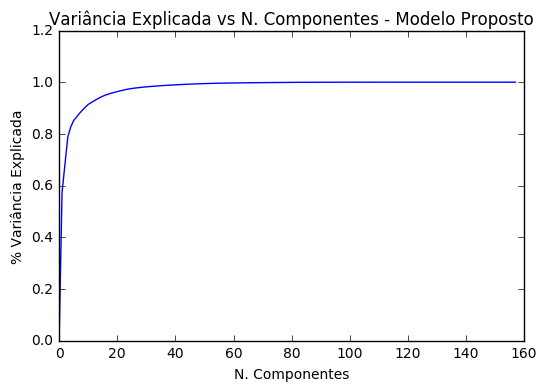

0
1
2
3
4
5
6
7


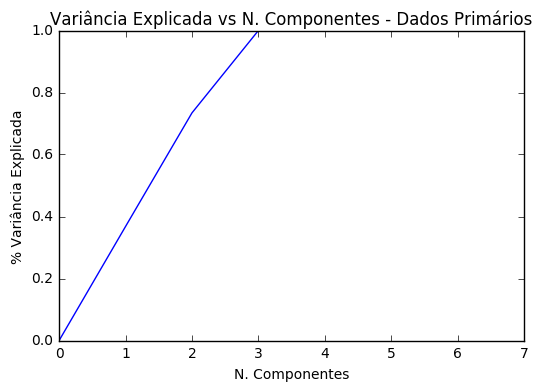

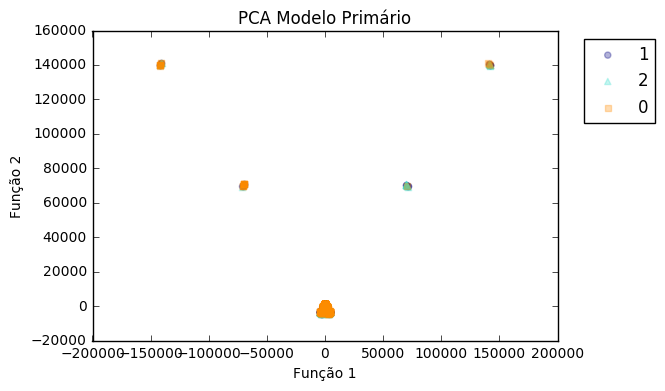

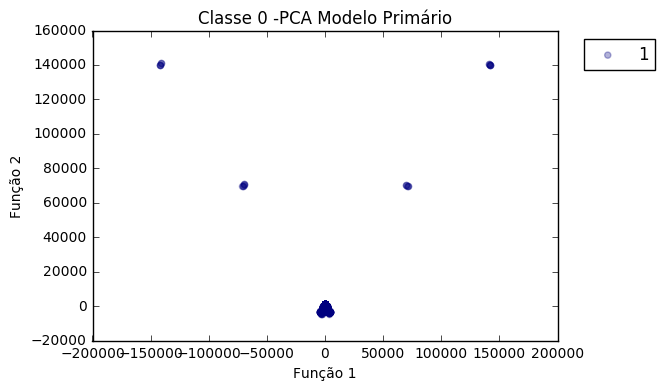

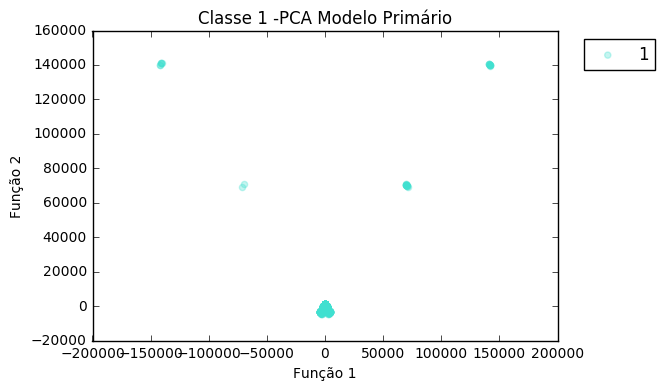

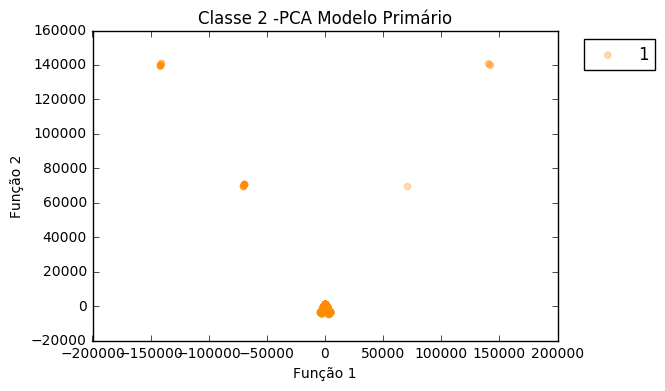

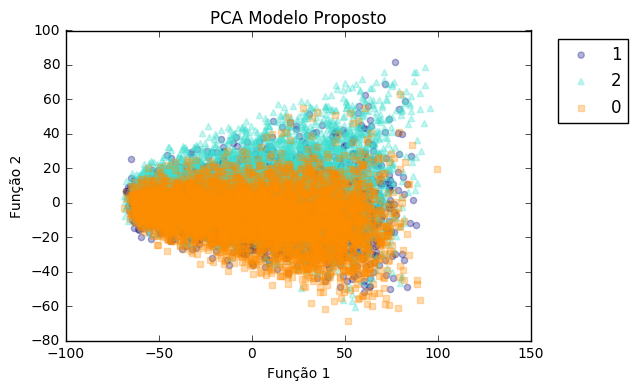

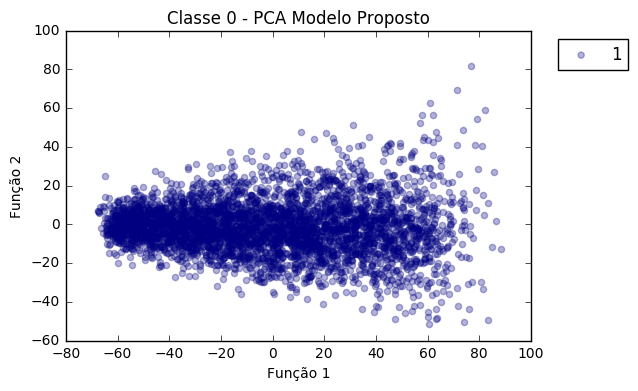

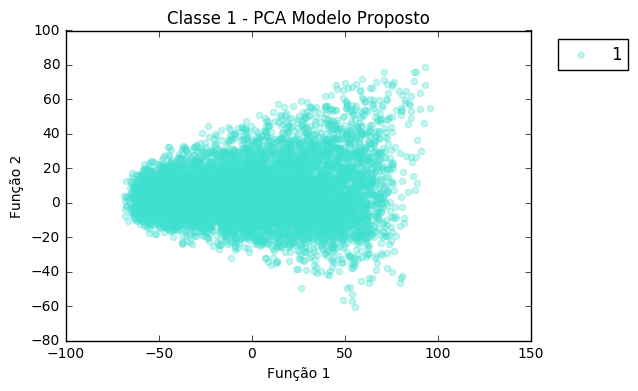

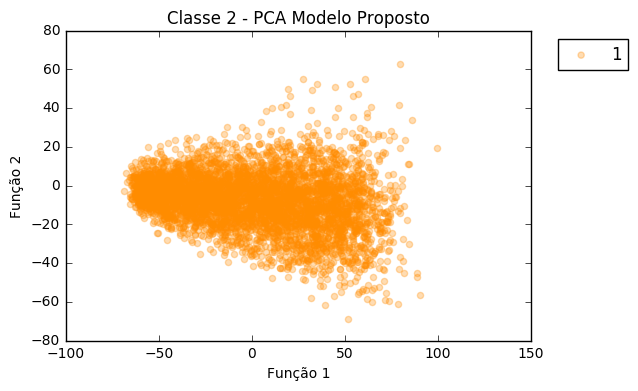

In [8]:
#PCA
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np
explained=[]
for i in range(len(ft)):
    pca = PCA(n_components=i)
    pca.fit(featured[ft]).transform(featured[ft])
    explained.append(np.sum(pca.explained_variance_ratio_))

plt.figure()
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.plot(range(0,len(ft)),explained)
plt.title(u'Variância Explicada vs N. Componentes - Modelo Proposto' )
plt.xlabel(u'N. Componentes')
plt.ylabel(u'% Variância Explicada')
plt.show()


explained=[]
for i in range(len(ft_raw)):
    print i
    pca = PCA(n_components=i)
    pca.fit(data[ft_raw]).transform(data[ft_raw])
    explained.append(np.sum(pca.explained_variance_ratio_))

plt.figure()
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.plot(range(0,len(ft_raw)),explained)
plt.title(u'Variância Explicada vs N. Componentes - Dados Primários' )
plt.xlabel('N. Componentes')
plt.ylabel(u'% Variância Explicada')
plt.show()

#RAW PCA GRAPHICS
pca = PCA(n_components=2)
X_r2= pca.fit(data[ft_raw]).transform(data[ft_raw])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

pca_train = pca.transform(train[ft_raw])
pca_val = pca.transform(val[ft_raw])
pca_test = pca.transform(test[ft_raw])


plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[data['Output'] == i, 0],X_r2[data['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'PCA Modelo Primário')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['navy'], [ 0], target_names,["o","^","s"]):
    plt.scatter(X_r2[data['Output'] == i, 0],X_r2[data['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'Classe 0 -PCA Modelo Primário')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['turquoise'], [1], target_names,["o","^","s"]):
    plt.scatter(X_r2[data['Output'] == i, 0],X_r2[data['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'Classe 1 -PCA Modelo Primário')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['darkorange'], [2], target_names,["o","^","s"]):
    plt.scatter(X_r2[data['Output'] == i, 0],X_r2[data['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'Classe 2 -PCA Modelo Primário')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

#Proposto PCA GRAPHICS

pca_ft = PCA(n_components=2)
X_r2= pca_ft.fit(featured[ft]).transform(featured[ft])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

pca_train_ft = pca_ft.transform(train_ft[ft])
pca_val_ft = pca_ft.transform(val_ft[ft])
pca_test_ft = pca_ft.transform(test_ft[ft])


plt.figure()

for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[featured['Output'] == i, 0],X_r2[featured['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'PCA Modelo Proposto')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')


plt.show()

plt.figure()

for color, i, target_name,m in zip(['navy'], [ 0], target_names,["o","^","s"]):
    plt.scatter(X_r2[featured['Output'] == i, 0],X_r2[featured['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'Classe 0 - PCA Modelo Proposto')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['turquoise'], [1], target_names,["o","^","s"]):
    plt.scatter(X_r2[featured['Output'] == i, 0],X_r2[featured['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Classe 1 - PCA Modelo Proposto')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['darkorange'], [2], target_names,["o","^","s"]):
    plt.scatter(X_r2[featured['Output'] == i, 0],X_r2[featured['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title('Classe 2 - PCA Modelo Proposto')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

In [9]:
logreg_pca_raw,nb_pca_raw,rf_pca_raw,gb_pca_raw,knn_pca_raw=all_algorithms(pca_train,pca_val,pca_test,train['Output'],val['Output'],test['Output'],seeds)

------ 1 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.332825197793 0.297116791079 0.371955233706
Naive Bayes 0.279837690009 0.21241906141 0.443054641211
Random F.   0.401081826129 0.373875958439 0.407504937459
G. Boost.   0.376729006697 0.332683602515 0.431533903884
KNN         0.405442217223 0.375150480964 0.421988150099
------ 2 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.332825197793 0.297116791079 0.371955233706
Naive Bayes 0.279837690009 0.21241906141 0.443054641211
Random F.   0.402393897603 0.375516493734 0.408821593153
G. Boost.   0.375692577988 0.330780922846 0.432850559579
KNN         0.405442217223 0.375150480964 0.421988150099
------ 3 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.332825197793 0.2971167910

In [10]:
logreg_pca_ft,nb_pca_ft,rf_pca_ft,gb_pca_ft,knn_pca_ft=all_algorithms(pca_train_ft,pca_val_ft,pca_test_ft,train_ft['Output'],val_ft['Output'],test_ft['Output'],seeds)

------ 1 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.280221603726 0.207171750301 0.450868427314
LogReg      0.424866786918 0.369234841643 0.502736140852
Naive Bayes 0.421526191769 0.364175313792 0.506067094932
Random F.   0.431189423228 0.398149502924 0.445871996193
G. Boost.   0.428988042455 0.377753342321 0.492981203902
KNN         0.442864316777 0.404167709273 0.470854151796
------ 2 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.280221603726 0.207171750301 0.450868427314
LogReg      0.424866786918 0.369234841643 0.502736140852
Naive Bayes 0.421526191769 0.364175313792 0.506067094932
Random F.   0.437218922349 0.404905379755 0.452058053771
G. Boost.   0.428807110589 0.377597355861 0.492743278611
KNN         0.442864316777 0.404167709273 0.470854151796
------ 3 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.280221603726 0.207171750301 0.450868427314
LogReg      0.424866786918 0.36923484

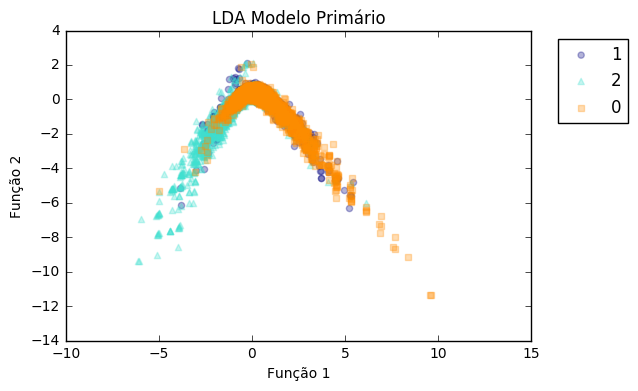

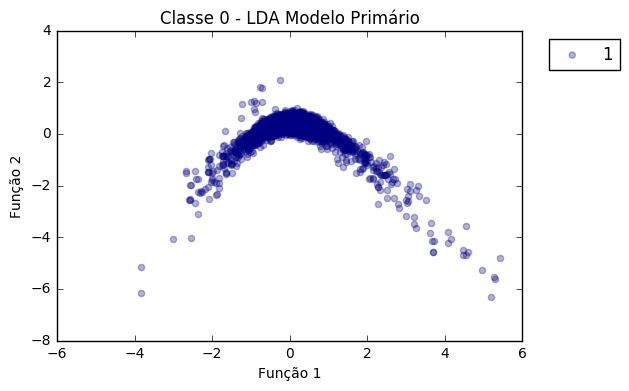

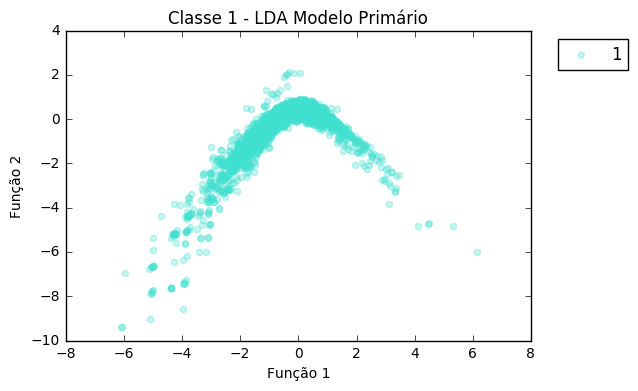

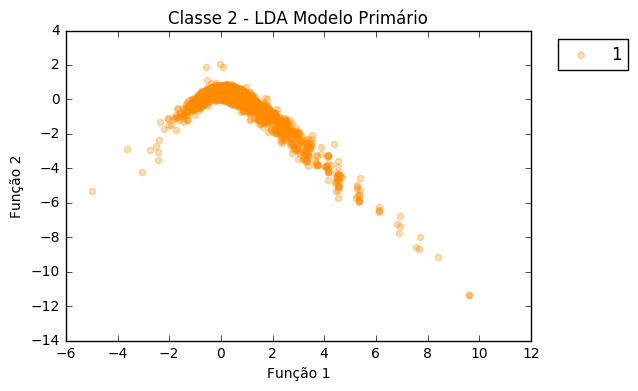

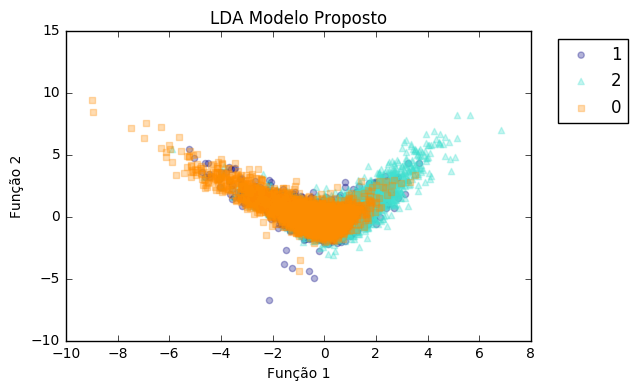

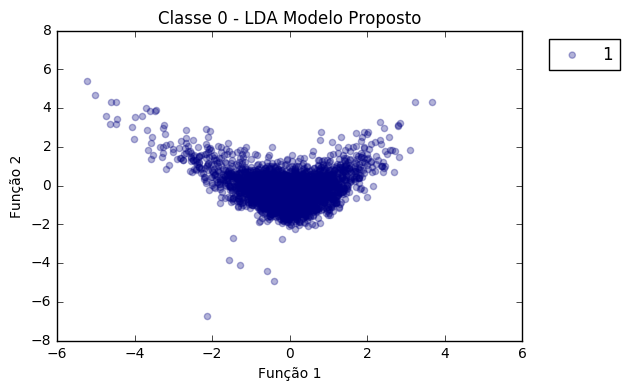

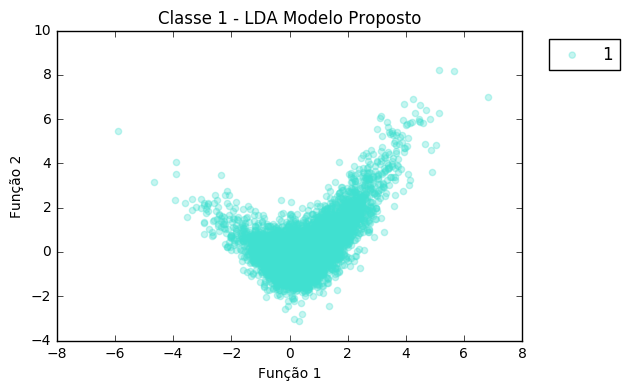

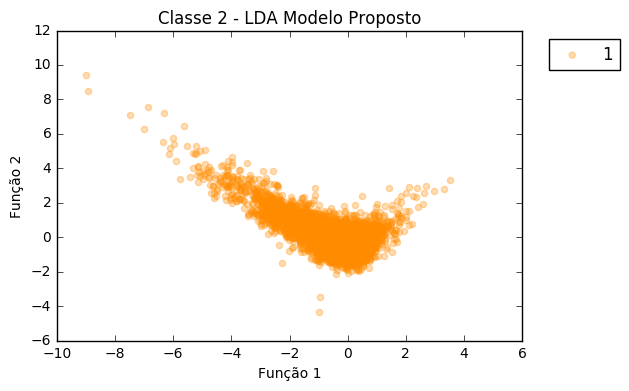

In [11]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(data[ft_raw],data['Output']).transform(data[ft_raw])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

lda_train = lda.transform(train[ft_raw])
lda_val = lda.transform(val[ft_raw])
lda_test = lda.transform(test[ft_raw])


for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[data['Output'] == i, 0],X_r2[data['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'LDA Modelo Primário')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['navy'], [ 0], target_names,["o","^","s"]):
    plt.scatter(X_r2[data['Output'] == i, 0],X_r2[data['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'Classe 0 - LDA Modelo Primário')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['turquoise'], [1], target_names,["o","^","s"]):
    plt.scatter(X_r2[data['Output'] == i, 0],X_r2[data['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'Classe 1 - LDA Modelo Primário')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['darkorange'], [2], target_names,["o","^","s"]):
    plt.scatter(X_r2[data['Output'] == i, 0],X_r2[data['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'Classe 2 - LDA Modelo Primário')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()


######################3



lda_ft = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda_ft.fit(featured[ft],featured['Output']).transform(featured[ft])
target_names = ['1', '2', '0']
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

lda_train_ft = lda_ft.transform(train_ft[ft])
lda_val_ft = lda_ft.transform(val_ft[ft])
lda_test_ft = lda_ft.transform(test_ft[ft])


for color, i, target_name,m in zip(colors, [ 0,1,2], target_names,["o","^","s"]):
    plt.scatter(X_r2[featured['Output'] == i, 0],X_r2[featured['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'LDA Modelo Proposto')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['navy'], [ 0], target_names,["o","^","s"]):
    plt.scatter(X_r2[featured['Output'] == i, 0],X_r2[featured['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'Classe 0 - LDA Modelo Proposto')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['turquoise'], [1], target_names,["o","^","s"]):
    plt.scatter(X_r2[featured['Output'] == i, 0],X_r2[featured['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'Classe 1 - LDA Modelo Proposto')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

plt.figure()

for color, i, target_name,m in zip(['darkorange'], [2], target_names,["o","^","s"]):
    plt.scatter(X_r2[featured['Output'] == i, 0],X_r2[featured['Output'] == i, 1],alpha=.3, color=color,
                label=target_name, marker=m)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left', shadow=False, scatterpoints=1)
plt.title(u'Classe 2 - LDA Modelo Proposto')
plt.xlabel(u'Função 1')
plt.ylabel(u'Função 2')

plt.show()

In [12]:
logreg_lda_raw,nb_lda_raw,rf_lda_raw,gb_lda_raw,knn_lda_raw=all_algorithms(lda_train,lda_val,lda_test,train['Output'],val['Output'],test['Output'],seeds)

------ 1 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.434264153281 0.381249394207 0.519420671494
Naive Bayes 0.466522549237 0.442605779766 0.468729427255
Random F.   0.453744869791 0.422070608957 0.465108624095
G. Boost.   0.446128943662 0.406967411321 0.471362738644
KNN         0.45362516329 0.412312109596 0.494733377222
------ 2 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.432880690965 0.379687453754 0.520078999342
Naive Bayes 0.466522549237 0.442605779766 0.468729427255
Random F.   0.458911096357 0.42859409339 0.469058591178
G. Boost.   0.453745730359 0.408109244206 0.511520737327
KNN         0.45362516329 0.412312109596 0.494733377222
------ 3 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.273770937608 0.205209994684 0.444700460829
LogReg      0.434264153281 0.38124939420

In [13]:
logreg_lda_ft,nb_lda_ft,rf_lda_ft,gb_lda_ft,knn_lda_ft=all_algorithms(lda_train_ft,lda_val_ft,lda_test_ft,train_ft['Output'],val_ft['Output'],test_ft['Output'],seeds)

------ 1 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.280221603726 0.207171750301 0.450868427314
LogReg      0.447066344948 0.391575863023 0.526766595289
Naive Bayes 0.479600924743 0.437851721591 0.515584106591
Random F.   0.469666965259 0.436112335404 0.484653818701
G. Boost.   0.462260354571 0.417281478001 0.507256721389
KNN         0.477758494255 0.433568156804 0.522721865334
------ 2 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.280221603726 0.207171750301 0.450868427314
LogReg      0.447066344948 0.391575863023 0.526766595289
Naive Bayes 0.479600924743 0.437851721591 0.515584106591
Random F.   0.471807517318 0.437663822753 0.487033071616
G. Boost.   0.456357560787 0.406601976112 0.514870330716
KNN         0.477758494255 0.433568156804 0.522721865334
------ 3 ------
LogReg
NB
RF
GB
KNN
		F1Score	      F1 macro	    F1 micro
Naive       0.280221603726 0.207171750301 0.450868427314
LogReg      0.447066344948 0.39157586

In [14]:
logreg_lda

NameError: name 'logreg_lda' is not defined